<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Masa_molowa                    100 non-null    float64
 1   LogP                           100 non-null    float64
 2   Liczba_ciezkich_atomow         100 non-null    int64  
 3   Donory_wiazania_wodorowego     100 non-null    int64  
 4   Akceptory_wiazania_wodorowego  100 non-null    int64  
 5   Pierscienie_aromatyczne        100 non-null    int64  
 6   TPSA                           100 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 5.6 KB


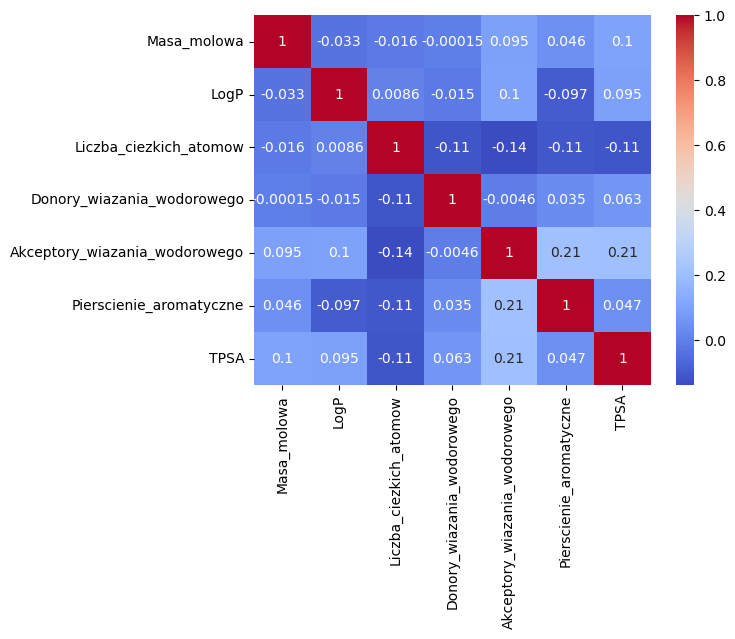

[0.21194585 0.16104492]


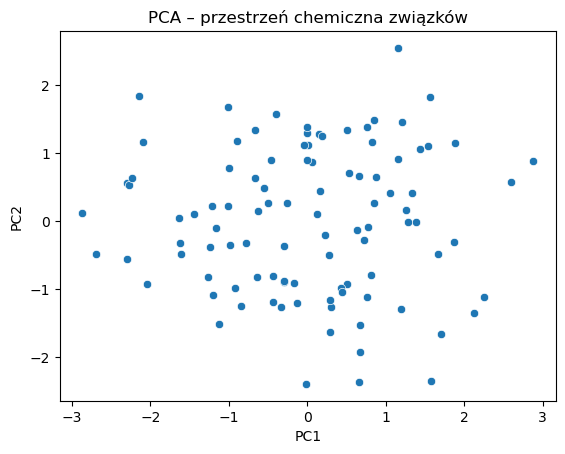

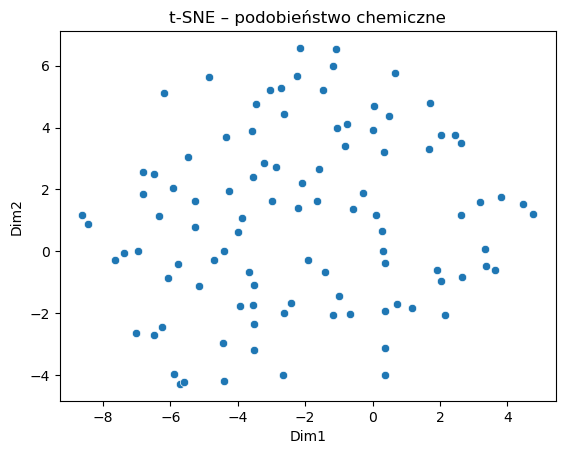

C:\Users\konra\anaconda3\envs\pum-25\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


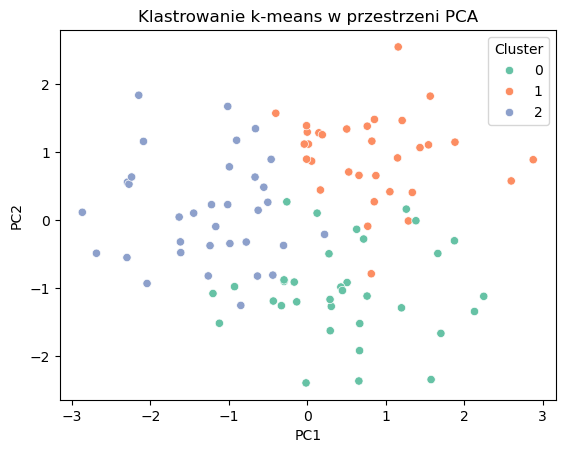


Metryki regresji Kp:
       Organ      RMSE        R2
0     Muscle  0.187136  0.939017
1       Bone  0.182786  0.916640
2      Brain  0.256403  0.936697
3      Heart  0.213953  0.920501
4  Intestine  0.229144  0.952167
5       Skin  0.216696  0.935615
6       Lung  0.274039  0.917008
7     Spleen  0.207848  0.925591

Zapisano plik: wyniki_Kp_i_powinowactwo_narzadow.csv


In [1]:
#1.1 Sprawdzenie jakości danych
import pandas as pd

df = pd.read_csv("dane_chemiczne.csv")

df.info()
df.describe()
df.isnull().sum()

#1.2 Analiza korelacji
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

#1.3 Normalizacja / standaryzacja cech
from sklearn.preprocessing import StandardScaler

features = df.columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

#2.1 PCA – analiza głównych składowych
from sklearn.decomposition import PCA

#podzielone na liczbę komponentów = 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Percentage of variance explained by each of the selected components.
# If n_components is not set then all components are stored and the sum
# of the ratios is equal to 1.0.
print(pca.explained_variance_ratio_)

#2.2 Wizualizacja PCA (Seaborn)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

sns.scatterplot(data=pca_df, x="PC1", y="PC2")
plt.title("PCA – przestrzeń chemiczna związków")
plt.show()

#2.3 t-SNE – nieliniowa redukcja wymiarów
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])

sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2")
plt.title("t-SNE – podobieństwo chemiczne")
plt.show()

#3.1 Klastrowanie k-średnich (k-means)
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=3,    # LICZBA KLASTRÓW (zmień tutaj)
    n_init=100  ,       # ILE RAZY algorytm uruchamia się z różnymi centroidami
    random_state=42
)
clusters = kmeans.fit_predict(X_scaled)

df["Cluster"] = clusters


#3.2 Wizualizacja klastrów w PCA
sns.scatterplot(
    x=pca_df["PC1"],
    y=pca_df["PC2"],
    hue=df["Cluster"],
    palette="Set2"
)
plt.title("Klastrowanie k-means w przestrzeni PCA")
plt.show()

#3.3 – Regresja Kp + klasyfikacja powinowactwa narządowego

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ==============================
# Wczytanie etykiet Kp
# ==============================
kp_df = pd.read_csv("kp_tkanki.csv")

organs = kp_df.columns.tolist()

# ==============================
# Dane wejściowe i wyjściowe
# ==============================
X = X_scaled
y = kp_df

# ==============================
# Podział danych
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==============================
# Model regresyjny (multi-output)
# ==============================
model = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# ==============================
# Predykcja Kp
# ==============================
y_pred = model.predict(X_test)

y_pred_df = pd.DataFrame(y_pred, columns=organs)

# ==============================
# Ewaluacja regresji
# ==============================
metrics = []

for i, organ in enumerate(organs):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])

    metrics.append({
        "Organ": organ,
        "RMSE": np.sqrt(mse),
        "R2": r2
    })

metrics_df = pd.DataFrame(metrics)
print("\nMetryki regresji Kp:")
print(metrics_df)

# ==============================
# 4. KLASYFIKACJA POWINOWACTWA NARZĄDOWEGO
# ==============================

# Normalizacja → procentowe powinowactwo
affinity_df = y_pred_df.div(y_pred_df.sum(axis=1), axis=0) * 100
affinity_df.columns = [f"{col}_Affinity_%"
                        for col in affinity_df.columns]

# Klasa = narząd o najwyższym powinowactwie
dominant_organ = affinity_df.idxmax(axis=1)
dominant_organ = dominant_organ.str.replace("_Affinity_%", "")
dominant_organ.name = "Dominant_Organ"

# ==============================
# 5. ZAPIS WYNIKU DO CSV
# ==============================

final_results = pd.concat(
    [
        y_pred_df.reset_index(drop=True),
        affinity_df.reset_index(drop=True),
        dominant_organ.reset_index(drop=True)
    ],
    axis=1
)

final_results.to_csv(
    "wyniki_Kp_i_powinowactwo_narzadow.csv",
    index=False
)

print("\nZapisano plik: wyniki_Kp_i_powinowactwo_narzadow.csv")
